# ANPR Image Preprocessing Pipeline

This notebook demonstrates the fundamental image preprocessing techniques used in **Automatic Number Plate Recognition (ANPR)** systems. The goal is to process raw vehicle images and identify potential license plate regions for further analysis.

## Workflow Overview
1. **Image Loading & Setup** - Load libraries and input image
2. **Grayscale Conversion** - Simplify image for processing
3. **Edge Detection** - Identify strong edges using Canny algorithm
4. **Noise Reduction** - Apply Gaussian blur to reduce artifacts
5. **Contour Detection** - Find connected components
6. **License Plate Filtering** - Apply heuristics to identify potential plates

---

## 1. Setup and Image Loading

First, we import the necessary libraries and load our test image. This section sets up the environment and loads a sample image containing a vehicle with a license plate.

In [192]:
# ANPR (Automatic Number Plate Recognition) - Image Preprocessing
# This notebook demonstrates basic image preprocessing techniques for license plate detection

# Import necessary libraries
import cv2  # OpenCV for computer vision operations
import matplotlib.pyplot as plt  # For displaying images in notebook
import numpy as np  # For numerical operations on image arrays

# Configure matplotlib to display plots inline in the notebook
%matplotlib inline

# Load the input image
# Using sample image '2.jpg' - this should contain a vehicle with visible license plate
image = cv2.imread("sample_images/5.jpg")

# Note: OpenCV loads images in BGR format (Blue-Green-Red) by default
print(f"Image shape: {image.shape}")  # Display image dimensions (height, width, channels)
print(f"Image dtype: {image.dtype}")  # Display data type of image array

Image shape: (480, 640, 3)
Image dtype: uint8


## 2. Grayscale Conversion

Converting the image to grayscale is a crucial first step in image processing. This reduces the computational complexity while preserving the structural information needed for edge detection and contour finding.

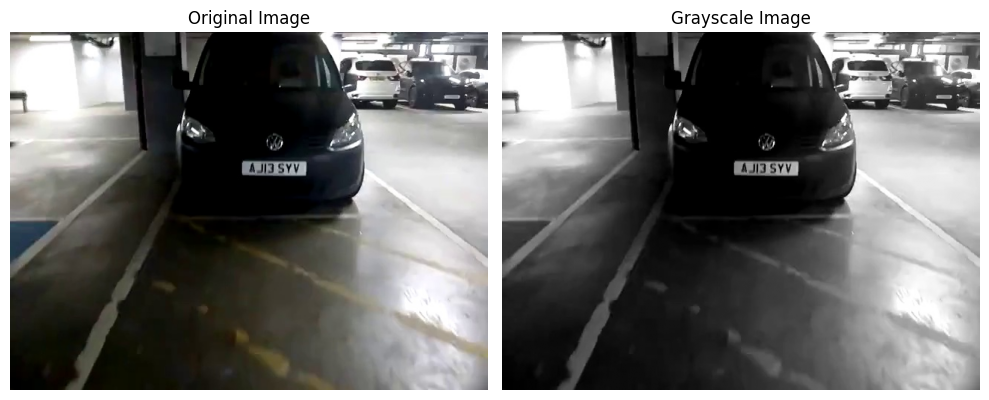

In [193]:
# Step 1: Convert to Grayscale
# Converting to grayscale reduces computational complexity and is often sufficient
# for edge detection and contour finding operations
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Edge Detection with Canny Algorithm

Edge detection is essential for identifying the boundaries of objects in the image. The Canny edge detector is particularly effective because it provides clean, well-connected edges while minimizing noise. This step helps highlight the rectangular boundaries of license plates.

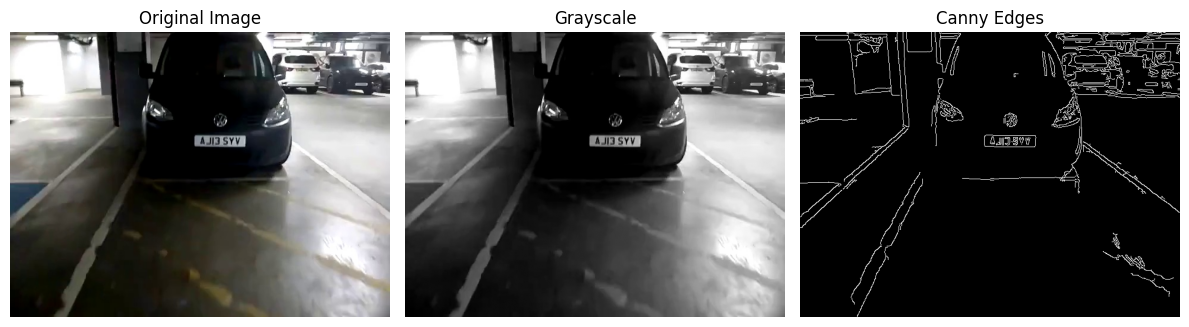

In [194]:
# Step 2: Edge Detection using Canny Algorithm
# Canny edge detection is effective for finding strong edges in images
# Parameters:
# - low_threshold (30): Pixels with gradient below this are not edges
# - high_threshold (200): Pixels with gradient above this are strong edges
# - Pixels between thresholds are edges only if connected to strong edges
edges = cv2.Canny(gray, 30, 200)

# Display the edge detection result
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gray, cmap='gray')
plt.title('Grayscale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edges')
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Noise Reduction with Gaussian Blur

Gaussian blur is applied to reduce noise and smooth the image before edge detection. This preprocessing step helps eliminate small artifacts and creates cleaner contours, which improves the accuracy of license plate detection.

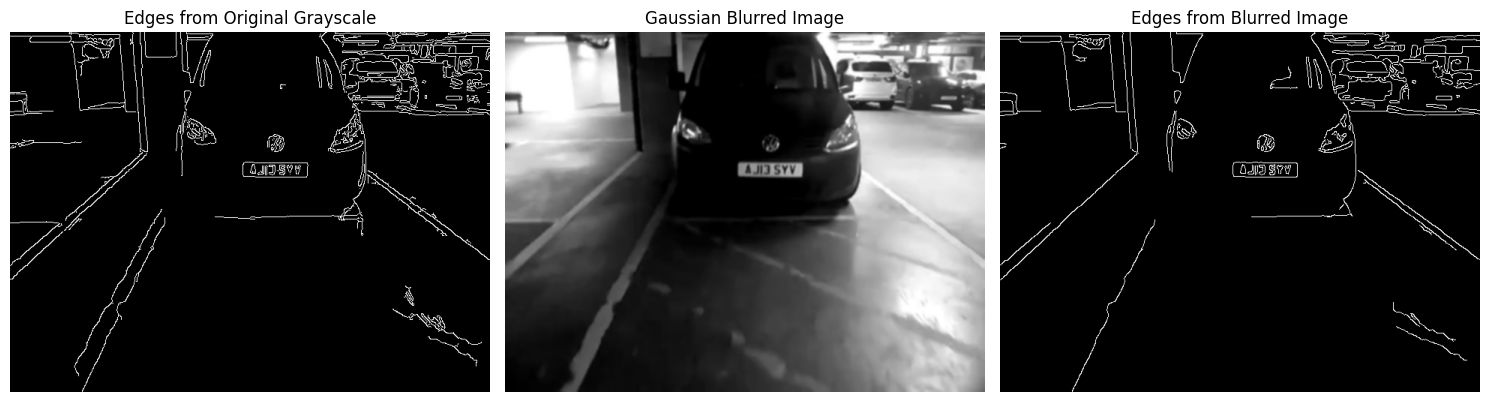

In [195]:
# Step 3: Gaussian Blur for Noise Reduction
# Gaussian blur helps reduce noise and smooth the image
# This can improve contour detection by removing small artifacts
# Parameters:
# - (5, 5): Kernel size - larger values create more blur
# - 0: Standard deviation (0 means calculate automatically from kernel size)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply edge detection to blurred image for comparison
edges_blurred = cv2.Canny(blurred, 30, 200)

# Compare edge detection results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges from Original Grayscale')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(edges_blurred, cmap='gray')
plt.title('Edges from Blurred Image')
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Contour Detection

Contours represent the boundaries of objects in the image. By finding contours from the edge-detected image, we can identify all potential rectangular regions that might contain license plates. This step converts edge pixels into meaningful shape information.

Total contours found: 237


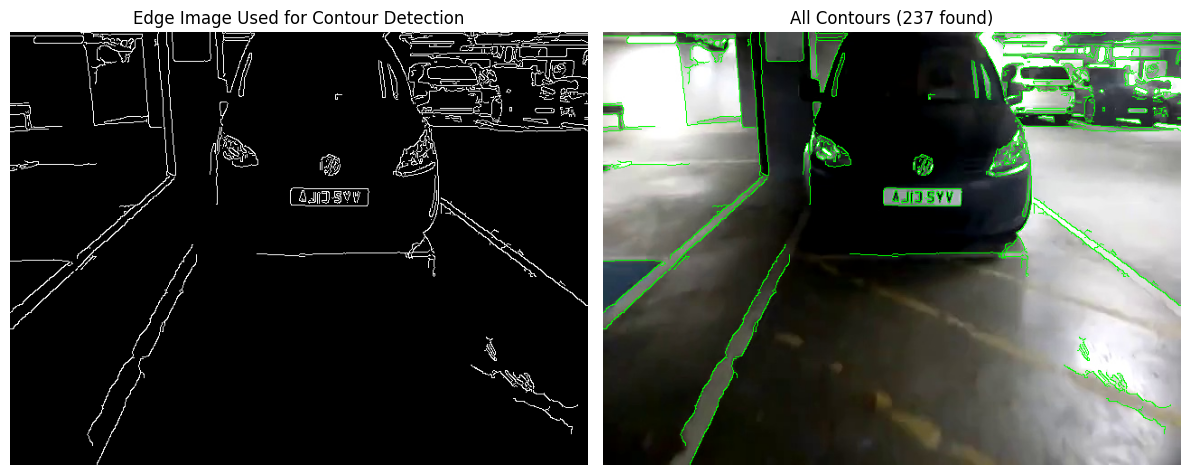

In [196]:
# Step 4: Find Contours
# Contours are curves joining continuous points with same color/intensity
# This helps identify potential rectangular regions (like license plates)
# Parameters:
# - cv2.RETR_TREE: Retrieves all contours and reconstructs full hierarchy
# - cv2.CHAIN_APPROX_SIMPLE: Compresses contour by removing redundant points
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print(f"Total contours found: {len(contours)}")

# Create a copy of the original image to draw all contours
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image Used for Contour Detection')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f'All Contours ({len(contours)} found)')
plt.axis('off')
plt.tight_layout()
plt.show()

Potential license plates found: 1
Plate 1: Size=359x157, Aspect Ratio=2.29, Area=56363


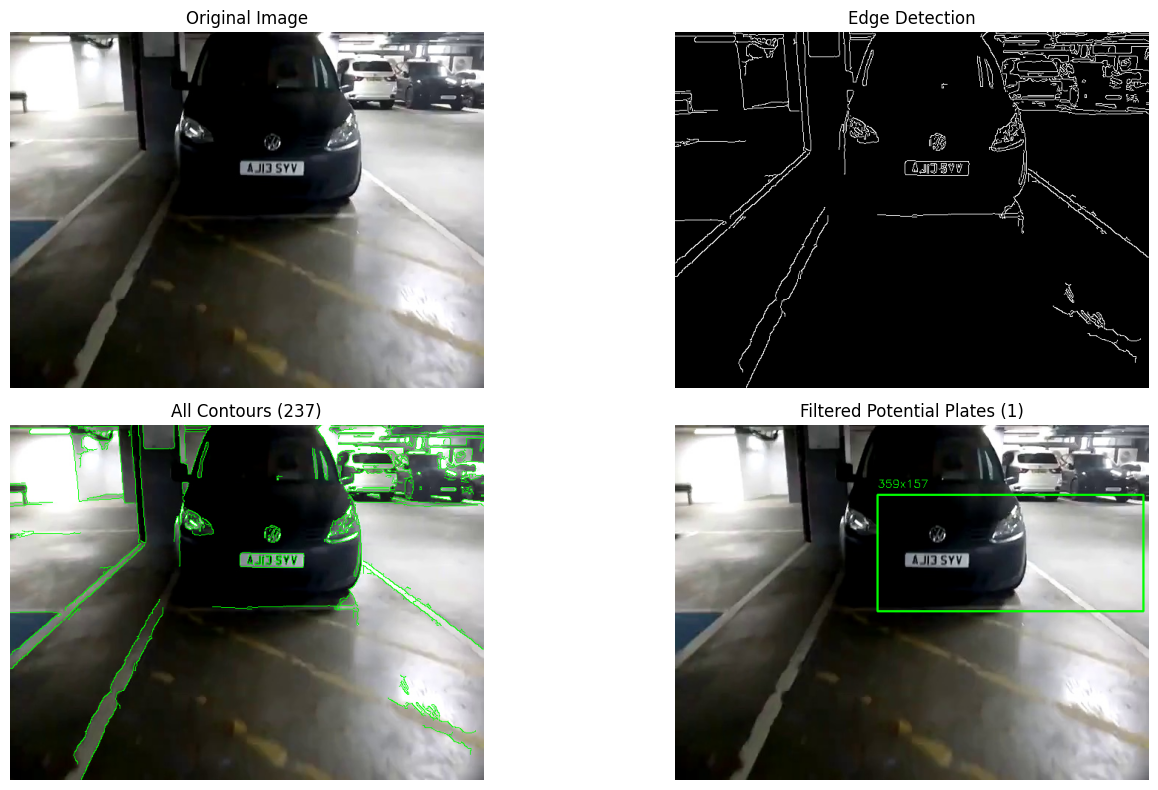

In [197]:
# Step 5: Filter Contours for Potential License Plates
# Apply heuristic filters to identify rectangular regions that could be license plates
# License plates typically have specific characteristics:
# - Rectangular shape with specific aspect ratio
# - Certain size range relative to image
# - Horizontal orientation

# Create a copy of the original image for drawing results
result_image = image.copy()
potential_plates = []

# Iterate through all contours and apply filtering criteria
for i, contour in enumerate(contours):
    # Get bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate aspect ratio (width/height)
    aspect_ratio = w / float(h)
    
    # License plate filtering criteria:
    # 1. Aspect ratio: License plates are typically 2-6 times wider than tall
    # 2. Width: Should be reasonable size (100-500 pixels)
    # 3. Height: Should be reasonable size (50-200 pixels)
    if 2.0 < aspect_ratio < 6.0 and 100 < w < 500 and 50 < h < 200:
        # Draw green rectangle around potential license plate
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Store information about this potential plate
        potential_plates.append({
            'contour_index': i,
            'x': x, 'y': y, 'w': w, 'h': h,
            'aspect_ratio': aspect_ratio,
            'area': w * h
        })
        
        # Add text label with dimensions
        cv2.putText(result_image, f'{w}x{h}', (x, y-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Potential license plates found: {len(potential_plates)}")
for i, plate in enumerate(potential_plates):
    print(f"Plate {i+1}: Size={plate['w']}x{plate['h']}, "
          f"Aspect Ratio={plate['aspect_ratio']:.2f}, Area={plate['area']}")

# Display the result
plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f'All Contours ({len(contours)})')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Filtered Potential Plates ({len(potential_plates)})')
plt.axis('off')

plt.tight_layout()
plt.show()

## 6. License Plate Region Filtering

This is the core filtering step where we apply heuristic rules to identify which contours are most likely to be license plates. We filter based on:

- **Aspect Ratio**: License plates are typically 2-6 times wider than they are tall
- **Size Constraints**: Reasonable minimum and maximum dimensions 
- **Shape Analysis**: Rectangular bounding boxes that match typical plate characteristics

The filtering criteria can be adjusted based on the specific license plate format in your region and the resolution of your input images.

## Summary and Key Takeaways

This notebook demonstrates basic image preprocessing techniques for **Automatic Number Plate Recognition (ANPR)**:

### Processing Pipeline:
1. **Grayscale Conversion** - Simplifies the image while retaining structural information
2. **Edge Detection** - Uses Canny algorithm to identify strong edges in the image
3. **Gaussian Blur** - Optional noise reduction step for cleaner edge detection
4. **Contour Detection** - Finds connected components that could represent objects
5. **Filtering** - Applies heuristic rules to identify potential license plate regions

### Key Parameters to Tune:
- **Canny thresholds** (30, 200): Adjust based on image contrast and noise
- **Aspect ratio range** (2.0-6.0): Depends on license plate format in your region
- **Size constraints** (100-500 width, 50-200 height): Scale with image resolution

### Next Steps for Improvement:
- Add morphological operations (opening/closing) for better noise removal
- Implement more sophisticated shape analysis (contour approximation)
- Use machine learning approaches for more robust plate detection
- Add perspective correction for angled license plates
- Implement character segmentation and OCR recognition

### Limitations of Current Approach:
- Relies on simple heuristics that may fail with unusual lighting or angles
- No validation of detected regions (could detect false positives)
- Doesn't handle multiple license plates in one image
- Sensitive to image quality and preprocessing parameters

---

## 7. Results and Analysis

Now let's examine the results of our preprocessing pipeline and analyze the effectiveness of our approach.